In [1]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
df = pd.read_csv(os.path.join('..', '..', 'data', 'yelp_data', 'updated', 'bussiness_with_corpus.csv'))
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,...,0,0,0,0,1,0,0,0,True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,...,0,0,0,0,0,0,0,1,False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,...,0,0,0,0,0,0,1,0,True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,...,0,0,0,0,0,0,1,0,True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,...,0,0,0,0,0,0,0,1,True,Contact Junction Tire Tires Auto Repair Shop i...


In [11]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', 'is_eng',
       'webpage_corpus'],
      dtype='object')

In [14]:
df = df[df['categories'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55963 entries, 0 to 56064
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      55963 non-null  int64  
 1   business_id     55963 non-null  object 
 2   name            55963 non-null  object 
 3   address         53592 non-null  object 
 4   city            55963 non-null  object 
 5   state           55963 non-null  object 
 6   postal_code     55854 non-null  object 
 7   latitude        55963 non-null  float64
 8   longitude       55963 non-null  float64
 9   stars           55963 non-null  float64
 10  review_count    55963 non-null  int64  
 11  is_open         55963 non-null  int64  
 12  attributes      48188 non-null  object 
 13  categories      55963 non-null  object 
 14  hours           45045 non-null  object 
 15  url             55963 non-null  object 
 16  webpage_text    50380 non-null  object 
 17  1.0             55963 non-null 

In [ ]:
df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


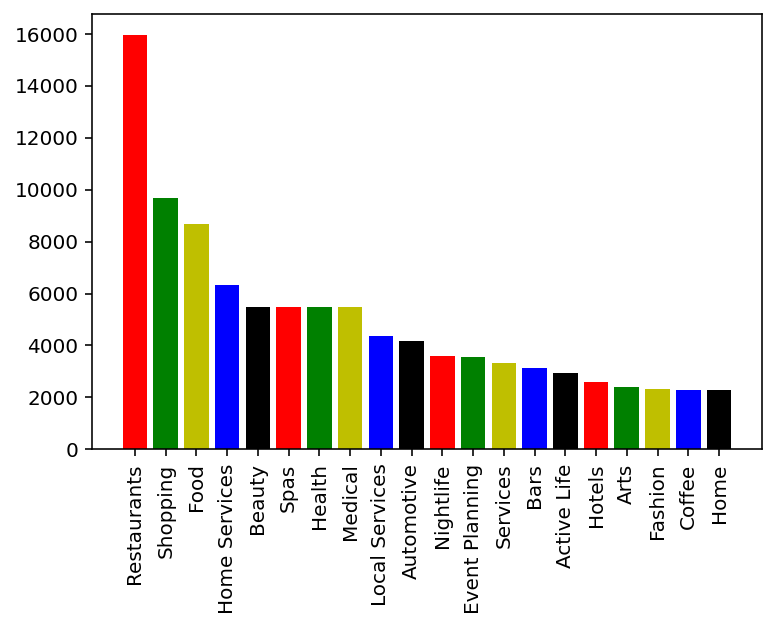

In [59]:
Categories={}

for x in df.categories:
    for cls in x:
        cls = cls.strip()
        if len(cls) < 2: continue
        if cls not in Categories: Categories[cls]=1
        else: Categories[cls]+=1

All_categories=list(Categories.keys())
classes=[[x,Categories[x]] for x in All_categories]
classes=sorted(classes, key=lambda x: x[1], reverse=True)
classes=classes[:20]

plt.bar(range(len(classes)),[x[1] for x in classes] ,align='center', color='rgybk')
plt.xticks(range(len(classes)), [x[0] for x in classes], rotation=90);